In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx

# import custom module
import SIRS

In [2]:
# needed only if you made some changes at SIRS.py and want to import the updated version of the module
from importlib import reload
reload(SIRS)

<module 'SIRS' from '/home/nicola/Nicola_unipd/QuintoAnno/Life Data Epidemiology/Project/LDE_project/SIRS.py'>

In [15]:
# parameters
N = 1000
I_sf = 5
I_er = 0
p_mob = 0.05
mean_degree = 4
eps = 0.1
beta = 0.09
mu = 0.085 # change this, it's the most unreasonable estimate
gamma = 0.01

In [16]:
# prepare systems
state_sf, state_er, variables_net_sf, variables_net_er = SIRS.prepare_two_sys(N, I_sf, I_er, 
                                                                              p_mob, mean_degree)

In [17]:
infection_params = dict(beta=beta, mu=mu, gamma=gamma)
infection_params

{'beta': 0.09, 'mu': 0.085, 'gamma': 0.01}

In [18]:
import time 
start = time.time()
n_iter = 1000
S_sf = []
I_sf = []
R_sf = []
S_er = []
I_er = []
R_er = []
t_vec = []
for i in range(n_iter):
    state_sf, state_er = SIRS.two_sys_full_SIRS_step(state_sf, state_er, **variables_net_sf, 
                                            **variables_net_er, **infection_params)
    S_sf.append(state_sf[:,0].sum())
    I_sf.append(state_sf[:,1].sum())
    R_sf.append(state_sf[:,2].sum())
    S_er.append(state_er[:,0].sum())
    I_er.append(state_er[:,1].sum())
    R_er.append(state_er[:,2].sum())
    t_vec.append(time.time()-start)
    
tot_time = time.time()-start
print("Total time elapsed: %.2f s"%tot_time)
print("Time per iteration: %.4f s"%(tot_time/n_iter))

S_sf = np.array(S_sf)
I_sf = np.array(I_sf)
R_sf = np.array(R_sf)
S_er = np.array(S_er)
I_er = np.array(I_er)
R_er = np.array(R_er)
t_vec = np.array(t_vec)

Total time elapsed: 37.70 s
Time per iteration: 0.0377 s


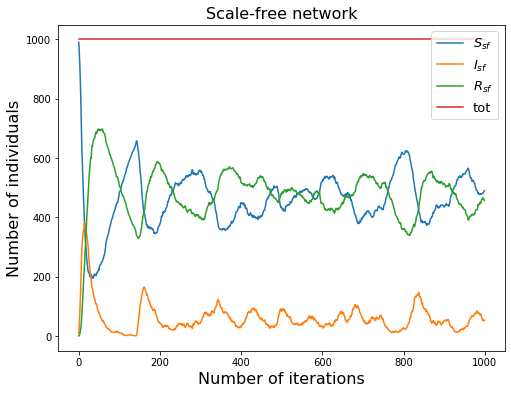

In [19]:
indexes = np.arange(n_iter)
plt.figure(figsize=(8,6))
plt.plot(indexes, S_sf, label = r'$S_{sf}$')
plt.plot(indexes, I_sf, label = r'$I_{sf}$')
plt.plot(indexes, R_sf, label = r'$R_{sf}$')
plt.plot(indexes, S_sf+I_sf+R_sf, label = 'tot')
plt.xlabel('Number of iterations', fontsize = 16)
plt.ylabel('Number of individuals', fontsize = 16)
plt.title("Scale-free network", fontsize = 16)
plt.legend(fontsize=13, loc='upper right')
plt.show()

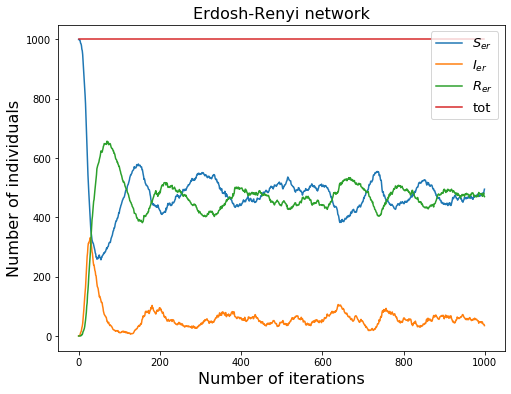

In [20]:
indexes = np.arange(n_iter)
plt.figure(figsize=(8,6))
plt.plot(indexes, S_er, label = r'$S_{er}$')
plt.plot(indexes, I_er, label = r'$I_{er}$')
plt.plot(indexes, R_er, label = r'$R_{er}$')
plt.plot(indexes, S_er+I_er+R_er, label = 'tot')
plt.title("Erdosh-Renyi network", fontsize = 16)
plt.xlabel('Number of iterations', fontsize = 16)
plt.ylabel('Number of individuals', fontsize = 16)
plt.legend(fontsize=13, loc='upper right')
plt.show()